In [1]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

allowed_color = 'Green'
polylog_color = 'Black'
noyhat_color = 'Orange'
giantstep_color = 'Blue'
notallowed_color = 'Red'
processnotdefined_color = 'Purple'
sweetspot_color = 'cyan'

In [2]:
from giant_learning.gradient_descent import ProjectedGradientDescent
from giant_learning.poly_poly import ProjectedH3H3Overlaps

import numpy as np
from sklearn.preprocessing import normalize
from scipy.linalg import orth
from tqdm import tqdm


target = ProjectedH3H3Overlaps._target
activation = ProjectedH3H3Overlaps._activation
activation_derivative = ProjectedH3H3Overlaps._activation_derivative

perfectlearning_color = 'Green'
saadsolla_color = 'Teal'
badlearning_color = 'Red'

p = 1
k = 1
d = 1000

n = [int(np.power(d,1/2))]

## Plot Table
labels_simulations = [f'Simulation d = {d}']
labels_theory = [f'Theory']
gammas = [10.*np.sqrt(1/d)]
I3activated = [True]
I4_diagonalactivated = [True]
I4_offdiagonalactivated = [True]
colors = [perfectlearning_color]

noise = 1e-4

T = 1

seed = [2,1,2]
read_simulation = False

# Initial conditions
# m0 = np.array([[.1,-.1],[.1,.1],[-.1,.1],[-.1,-.1]]) + np.random.normal(0,.1,(p,k))
m0 = np.array([[.0,]]) + np.random.normal(0,.1,(p,k))
norm = lambda w: np.linalg.norm(w, ord=2, axis=1, keepdims=True)

weight_teacher = np.random.normal(0,1, (k,d))
weight_teacher = weight_teacher / norm(weight_teacher)
weight_teacher = orth(weight_teacher.T).T 

Wtild = np.random.normal(size=(p,d)) 
Wtild = Wtild / norm(Wtild) 
Wtild_over_Wtarget = np.einsum('ji,ri,rh->jh', Wtild , weight_teacher ,weight_teacher) 

Worth =  Wtild - Wtild_over_Wtarget
Worth = Worth / norm(Worth) 
Worth = orth(Worth.T).T 

W0 = m0 @ weight_teacher + np.einsum('j,ji->ji',np.sqrt(1-np.linalg.norm(m0,ord=2,axis=1)**2),Worth)
Wtarget = weight_teacher

a0 = np.zeros((p))
P = Wtarget @ Wtarget.T
M0 = W0 @ Wtarget.T
Q0 = W0 @ W0.T

print(f'P = {P}')
print(f'M0 = {M0}')
print(f'Q0 = {Q0}')

test_errors_simulation = np.zeros((len(gammas), T+1))
test_errors_theory = np.zeros((len(gammas), T+1))


for i,gamma in enumerate(gammas):
    print(f'P = {P}')
    print(f'M0 = {M0}')
    print(f'Q0 = {Q0}')
    gd = ProjectedGradientDescent(
        target, Wtarget, n[i],
        activation, W0, a0, activation_derivative, 
        gamma, noise, second_layer_update = False, test_size = None, analytical_error= 'H3H3',
        seed=seed[i]^i
    )
    th = ProjectedH3H3Overlaps(
        P, M0, Q0, a0,
        gamma, noise,
        I4_diagonal=I4_diagonalactivated[i], I4_offdiagonal=I4_offdiagonalactivated[i], I3=I3activated[i],
        second_layer_update=False
    )
    print(gd.test_errors[0], th.test_errors[0])
    
    if read_simulation:
        gd.test_errors = np.load(f'data_warm_startH2/Simulated, {labels_simulations[i]}_{T}.npz')['arr_0']
    else:
        gd.train(T, verbose=True)
        np.savez(f'data_warm_startH2/Simulated, {labels_simulations[i]}_{T}.npz', gd.test_errors)
    test_errors_simulation[i, :] = gd.test_errors

    th.train(T, verbose=True)
    test_errors_theory[i, :] = th.test_errors

    print(th.Ms)




ImportError: cannot import name 'SphericalH3H3Overlaps' from 'giant_learning.poly_poly' (/Users/lucaarnaboldi/Desktop/staircase-ss/giant-learning/giant_learning/poly_poly.py)

[[3. 3.]]
[[3. 3.]]


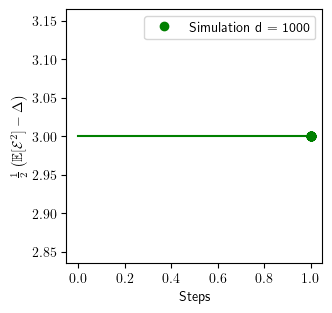

In [ ]:
number_of_plotted_points = 20

nonoise_test_errors_simulation = test_errors_simulation - noise/2
nonoise_test_errors_theory = test_errors_theory -noise/2

# nonoise_test_errors_simulation[0] += 7.*noise
# nonoise_test_errors_theory[2] -= noise/2

print(nonoise_test_errors_simulation)
print(nonoise_test_errors_theory)

fig, ax = plt.subplots(figsize=(3.3, 3.3))

for i, gamma in enumerate(gammas):
    plotted_T = np.logspace(0,np.log10(T),num=number_of_plotted_points, dtype=int)
    ax.plot(plotted_T,nonoise_test_errors_simulation[i][plotted_T], marker='o', linestyle='', label=labels_simulations[i], color=colors[i])
    ax.plot(nonoise_test_errors_theory[i], linestyle='-',  color=colors[i])

# ax.legend(gammas)
ax.set_xlabel('Steps')
ax.set_ylabel(r'$\frac{1}{2}\left(\mathbb{E}[\mathcal{E}^2]-\Delta\right)$')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1,1e5)
# ax.set_ylim(1e-2,5e-1)
ax.legend()

plt.savefig('figures/dynamicsH2[multindex].pdf', bbox_inches = 'tight')
plt.show()
